# Project description

We need to evaluate results of an A/B test. We have at our disposal a dataset with user actions, a technical task and several additional datasets. We will be testing changes related to the introduction of an improved recommending system. Expected results: within 14 days from the moment of registration, users will show an improvement of each metric by at least 10%. Measured metrics: conversions to product card views, cart views, and purchases. We will have to evaluate the correctness of the test and analyze its results.

<b> The purpose of the project</b>: we need to determine whether the changes in the recommending system led to an improvement in user conversion.

### Technical task

- Test name: `recommender_system_test`;
- groups: A - control, B - new payment funnel;
- launch date: 2020-12-07;
- date of stopping the recruitment of new users: 2020-12-21;
- stop date: 2021-01-04;
- audience: 15% of new users from the EU region;
- purpose of the test: testing changes associated with the introduction of an improved recommending system;
- expected number of test participants: 6000.
- expected effect: in 14 days from the moment of registration, users will show an improvement in each metric by at least 10%:
     - conversions to view product cards — `product_page` event,
     - cart views — `product_cart`,
     - purchases - `purchase`.

## Processing data from a file

In [79]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math as mth
from scipy import stats as st
from datetime import date
import os

In [80]:
os.chdir('C:\\Users\\Владислав\\Documents\\Проекты\\datasets')

In [81]:
m_events = pd.read_csv('ab_project_marketing_events.csv')
m_events.info()
m_events.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [82]:
new_users = pd.read_csv('final_ab_new_users.csv')
new_users.info()
new_users.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
48237,02CC199625AFDAE6,2020-12-12,EU,Android
30424,7B48E72587EFD2C5,2020-12-16,EU,iPhone
41509,4CF8E8855FB1A493,2020-12-11,EU,iPhone
16079,4734A67AF2ABE4A2,2020-12-21,EU,PC
31356,8EE10B875F4C87FB,2020-12-23,EU,PC


In [83]:
events = pd.read_csv('final_ab_events.csv')
events.info()
events.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
430731,461D7854B605AAB9,2020-12-27 23:34:25,login,NaN
381054,D782133D1D8B85BE,2020-12-22 21:08:44,login,NaN
65035,AC4949137A02EAA0,2020-12-08 06:02:05,product_cart,NaN
415170,D65AC7DF92658B02,2020-12-25 03:13:54,login,NaN
195543,474B8825FC16CBFB,2020-12-20 15:30:27,product_page,NaN


In [84]:
participants = pd.read_csv('final_ab_participants.csv')
participants.info()
participants.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
4289,5DD8AA22AD471522,A,recommender_system_test
2266,CFF7906685D67807,B,recommender_system_test
3612,F96F169EAD97EA46,A,recommender_system_test
1183,AA364AF6A253170F,A,recommender_system_test
6544,5036F8CD09C38E31,B,recommender_system_test


### Converting data types

In [85]:
m_events['start_dt'] = pd.to_datetime(m_events['start_dt'])
m_events['finish_dt'] = pd.to_datetime(m_events['finish_dt'])
m_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [86]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [87]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


### Duplicates

In [88]:
m_events.duplicated().sum()

0

In [89]:
events.duplicated().sum()

0

In [90]:
new_users.duplicated().sum()

0

In [91]:
participants.duplicated().sum()

0

### Processing missing data

In [92]:
m_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [93]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [94]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [95]:
events.query('event_name == "purchase"')['event_name'].count()

62740

We've discovered some missing data in the column "details", there we specify order totals.

In [96]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [97]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Let's merge participants with new_users, and then merge this table with the events table so that we have complete information about the events of our users.

In [98]:
df_p = participants.merge(new_users, on='user_id', how = 'left')
df_p.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [99]:
df_p['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [100]:
df_p['region'].unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

In [101]:
df_p['device'].unique()

array(['PC', 'iPhone', 'Mac', 'Android'], dtype=object)

We have access to data from 4 dataframes: marketing activity, user events, new users and test participants. At the first stage of data preprocessing, we converted the data to the required types, checked the tables for missing information. Missing information was found only in the order amount column, which is understandable, if the "purchase" event did not occur, then the cell would remain empty. No duplicates were found. We also combined our dataframes to have more information about the test participants.

The dataset contains information about two tests: recommender_system_test and interface_eu_test. Our users came to us from the following regions: EU, North America, CIS and Asia-Pacific, they also used the following devices: PC, iPhone, Mac and Android.

## Evaluation of A/B testing validity

### Analyzing compliance with the technical task

<b>1. Name of the test: recommender_system_test

In [102]:
df_p['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In our dataframe there is information for two A/B tests, let's leave only the users who participated in the 'recommender_system_test'.

In [103]:
df_p.query('ab_test == "interface_eu_test"')['user_id'].nunique()

11567

In [104]:
df_p.query('ab_test == "recommender_system_test"')['user_id'].nunique()

6701

recommender_system_test had 6701 participants and interface_eu_test had 11 567 participants.

In [105]:
df_p = df_p.query('ab_test == "recommender_system_test"')

In [106]:
df_e = events.merge(df_p, on='user_id', how='left')

In [107]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440317 entries, 0 to 440316
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   group       24698 non-null   object        
 5   ab_test     24698 non-null   object        
 6   first_date  24698 non-null   datetime64[ns]
 7   region      24698 non-null   object        
 8   device      24698 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 33.6+ MB


In [108]:
df_e = df_e.query('ab_test == "recommender_system_test"')

In [109]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 5 to 440289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24698 non-null  object        
 1   event_dt    24698 non-null  datetime64[ns]
 2   event_name  24698 non-null  object        
 3   details     3331 non-null   float64       
 4   group       24698 non-null  object        
 5   ab_test     24698 non-null  object        
 6   first_date  24698 non-null  datetime64[ns]
 7   region      24698 non-null  object        
 8   device      24698 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.9+ MB


<b>2. Let's check that we have two groups: A - a control group, B - a new payment funnel.

In [110]:
df_p['group'].unique()

array(['A', 'B'], dtype=object)

<b>3. Launch date: 2020-12-07

In [111]:
df_e['event_dt'].min()

Timestamp('2020-12-07 00:05:57')

In [112]:
df_p['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Launch date is in accordance with the technical requirements.

<b>4. The date when new user recruitment was stopped: 2020-12-21.

In [113]:
df_p['first_date'].max()

Timestamp('2020-12-21 00:00:00')

<b>5. Test stop date: 2021-01-04

In [114]:
df_e['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

The last event in our dataframe happende on 12/30/2021, which means that we finished the test before our deadline, which can lead to a "peeping problem" where our p-value may prematurely reach the boundaries of statistical significance.

<b>6. Target audience: 15% of new users from the EU region

In [115]:
df_p['region'].unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

In [116]:
#calculating the number of users by region
regions = df_p.pivot_table(index='region', values='user_id', aggfunc='nunique')
regions['percent'] = round((regions['user_id']/sum(regions['user_id'])) *100.00, 2)
regions

,user_id,percent
region,,
APAC,72,1.07
CIS,55,0.82
EU,6351,94.78
N.America,223,3.33


95% of users came from the EU region, 3% from North America and 1% each from the Asia-Pacific region and the CIS.

In [117]:
#calculating how many new users from the EU region participated in the test
inter = np.intersect1d(new_users.query('region == "EU"')['user_id'].unique(),\
                   df_p.query('region == "EU"')['user_id'].unique())

In [118]:
eu = np.count_nonzero(inter)
eu

6351

In [119]:
#setting start and finish dates of the test 
start = date(2020,12,7)
finish = date(2020,12,21)

In [120]:
#let's limit the dataset of new users to the time of our test
# then calculate the total number of new users by region

new = new_users.query('first_date >= @start  & first_date <= @finish')\
.pivot_table(index='region', values='user_id', aggfunc='nunique').reset_index()
new

,region,user_id
0,APAC,2883
1,CIS,2900
2,EU,42340
3,N.America,8347


In [121]:
#calculating the percentage of new users from EU region
round(eu/new.query('region == "EU"')['user_id'], 2)

2    0.15
Name: user_id, dtype: float64

According to our technical tasks, at least 15% of new users from the EU region should be involved in the test. Our data corresponds with the task.

<b>7. Events must occur within a 14-day lifetime from users' registration date.

Next we are working with the events dataset, we will delete users who have not performed any actions.

In [122]:
df_e.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,recommender_system_test,2020-12-07,EU,iPhone
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,recommender_system_test,2020-12-07,EU,PC


In [123]:
#calculating lifetimes for all users' actions
df_e['lifetime'] = (df_e['event_dt'] - df_e['first_date']).dt.days

In [124]:
#calculationg the number of actions that occurred after the 14 day period
df_e.query('lifetime > 14')['user_id'].count()

628

628 events occurred outside of the users' 14-day lifetime. I propose to get rid of these events so that they are not taken into account for the calculation of the funnel.

In [125]:
#limiting the dataframe
df_e = df_e.query('lifetime <= 14')

<b> 8. Expected number of users - 6000.

In [126]:
df_e['user_id'].nunique()

3675

After cleaning the dataset to match the testing requirements, we were left with only 3675 users, which is well below the expected number of users needed for the study.

<b> 9. Expected effect: in 14 days from the moment of registration, users will show an improvement in each metric by at least 10%

Let's set the login stage as the first stage of users journey, then product_page (viewing the product card), product_cart (adding the product to the cart) and the final stage - purchase.

In [127]:
#grouping users in group A at different stages of the funnel
group_a = df_e.query('group == "A"').pivot_table(index='event_name', values = 'user_id', aggfunc = 'nunique').reset_index()
group_a['order'] = [1, 3, 2, 4]
group_a

,event_name,user_id,order
0,login,2747,1
1,product_cart,824,3
2,product_page,1780,2
3,purchase,872,4


In [128]:
#sorting funnel stages
group_a = group_a.sort_values(by='order', ascending = True)
group_a = group_a.drop('order', axis=1)
group_a

,event_name,user_id
0,login,2747
2,product_page,1780
1,product_cart,824
3,purchase,872


In [129]:
#grouping users in group A at different stages of the funnel
group_b = df_e.query('group == "B"').pivot_table(index='event_name', values = 'user_id', aggfunc = 'nunique').reset_index()
group_b['order'] = [1, 3, 2, 4]
group_b

,event_name,user_id,order
0,login,927,1
1,product_cart,255,3
2,product_page,523,2
3,purchase,256,4


In [130]:
#sorting funnel stages
group_b = group_b.sort_values(by='order', ascending = True)
group_b = group_b.drop('order', axis=1)
group_b

,event_name,user_id
0,login,927
2,product_page,523
1,product_cart,255
3,purchase,256


In [131]:
#building a funnel
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = group_a['event_name'],
    x = group_a['user_id'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = group_b['event_name'],
    x = group_b['user_id'],
    textinfo = "value+percent initial")
             
             )

fig.update_layout(title="Conversion Funnel in Group A and B")

fig.show()

On the funnel chart, you can see that the conversions at all stages in group B, not only did not improve by 10% compared to the control group, but worsened.

While checking the data for compliance with our technical task we found that we had access to data not only for our target test, but also for an interface test . Unnecessary data was cut off, leaving only those users who participated in our target test and performed at least one action, including the login stage. We checked the data for compliance with the time frame and region of the study. Unfortunately, after all the cutoffs, we have a smaller number of users than expected, only 3675. In addition, during the preliminary conversion assessment, we found a significant deterioration in conversion at all stages, how significant this deterioration is, we will investigate further.

### Analyzing the influence of marketing events on the AB test

In [132]:
m_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [133]:
#adding a row with the ab test to the df with marketing activities 
m_events.loc[len(m_events.index)] = ['Test','EU, CIS, APAC, N.America', date(2020,12,7), date(2021,1,4)]

In [134]:
#let's build a Gantt chart to visualize our marketing activities
fig = px.timeline(m_events, x_start="start_dt", x_end="finish_dt", y="name")
fig.update_yaxes(autorange="reversed")
fig.show()

As you can see, our test intersects with two marketing activities CIS New Year Gift Lottery and Christmas&New Year Promo. When we consider the distribution of user activity, we will need to pay attention to the periods of these marketing campaigns and check whether we will have bursts of user activity during this period.

### Evaluating target groups

Firstly, let's see if there are any intersections between group A and B in our recommender_system_test test.

In [135]:
#countingg intersections
inter = np.intersect1d(df_e.query('group == "A"')['user_id'].unique(),\
                      df_e.query('group == "B"')['user_id'].unique())

In [136]:
np.count_nonzero(inter)

0

No intersections were found.

Then let's make sure the same users didn't participate in both test, including interface_eu_test. 

In [137]:
#counting intersections of users in different tets
inter = np.intersect1d(df_e['user_id'].unique(),\
                      participants.query('ab_test == "interface_eu_test"')['user_id'].unique())

In [139]:
#counting how many users participated in both tests
np.count_nonzero(inter)

887

887 users were in two tests at the same time. That is, the behavior of these users may have been influenced by any of our tests. Ideally, such users would need to be excluded for the purity of the experiment, however, we already have very little data left for analysis. Therefore, we will still consider these users and assume that it was our target test that influenced their behavior.

During the verification of the correctness of the AB test, the following errors were found:
- not all the requirements of the technical task were met;
- the test was stopped prematurely, which may lead to false results;
- conducting two AB tests at the same time. In such cases, it is difficult to distinguish between the effect of the introduced changes on users, since it is not clear which of them led to a certain result;
- in addition, we found some marketing activities took place at the same time while the AB testing was performed, which could also affect the results.

Unfortunately, these errors may call into question the correctness of the data and the conduct of the test as a whole.

## Exploratory data analysis

### Number of events per user in two groups

In [140]:
df_e.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,lifetime
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC,0
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,recommender_system_test,2020-12-07,EU,iPhone,0
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC,0
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,recommender_system_test,2020-12-07,EU,PC,0


In [141]:
#calculating the average number of events per user in group A
df_e.query('group == "A"').pivot_table(index='user_id', values='event_name', aggfunc = 'count').mean()

event_name    6.897343
dtype: float64

In [142]:
avg_a = df_e.query('group == "A"').pivot_table(index='user_id', values='event_name', aggfunc = 'count').reset_index()
avg_a.head()

,user_id,event_name
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,006E3E4E232CE760,6


In [143]:
#calculating the average number of events per user in group B
df_e.query('group == "B"').pivot_table(index='user_id', values='event_name', aggfunc = 'count').mean()

event_name    5.520474
dtype: float64

In [144]:
avg_b = df_e.query('group == "B"').pivot_table(index='user_id', values='event_name', aggfunc = 'count').reset_index()
avg_b.head()

,user_id,event_name
0,001064FEAAB631A1,6
1,005E096DBD379BCF,4
2,015D1E3BB893349D,6
3,015FF3EC72C1F4F6,2
4,01B0B891CA513468,12


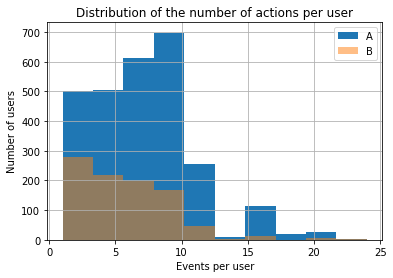

In [145]:
avg_a['event_name'].hist(label = "A")

plt.xlabel('Events per user')
plt.ylabel('Number of users')
plt.title('Distribution of the number of actions per user')

avg_b['event_name'].hist(alpha = 0.5, label = "B")
plt.legend()

On average, there are 6 events per 1 user in group A, and 5 events in group B.

### Number of events per day in two groups

In [146]:
#adding a column with the date of the event
df_e['date'] = df_e['event_dt'].dt.date

In [147]:
#creating two datasets of the number of events grouped by date
a = df_e.query('group == "A"').pivot_table(index='date', values='event_name', aggfunc = 'count').reset_index()
b = df_e.query('group == "B"').pivot_table(index='date', values='event_name', aggfunc = 'count').reset_index()

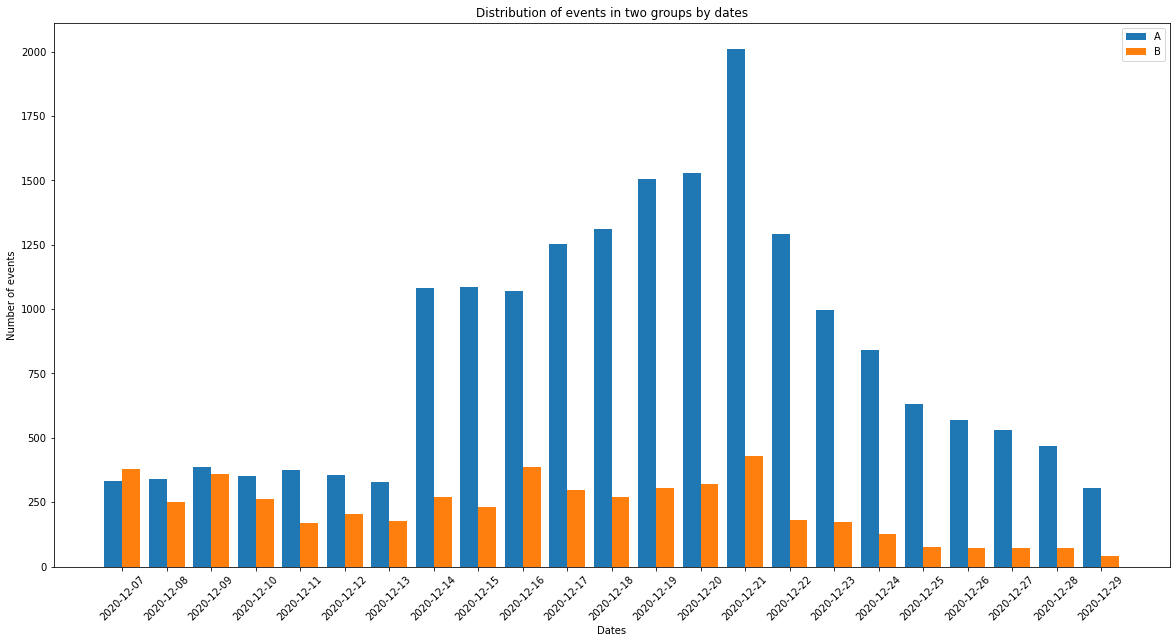

In [148]:
#let's visualize the distribution
X = a['date']
Y = a['event_name']
Z = b['event_name']
  
X_axis = np.arange(len(X))

plt.figure(figsize=(20, 10))
plt.bar(X_axis - 0.2, Y, 0.4, label = 'A')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'B')

plt.xticks(X_axis, X, rotation = 45)
plt.xlabel("Dates")
plt.ylabel("Number of events")
plt.title("Distribution of events in two groups by dates")
plt.legend()
plt.show()

The graph shows that the set of users in groups was fairly even until December 14th, but after this date we see a significant preponderance of users in group A.

Text(0, 0.5, 'Number of users')

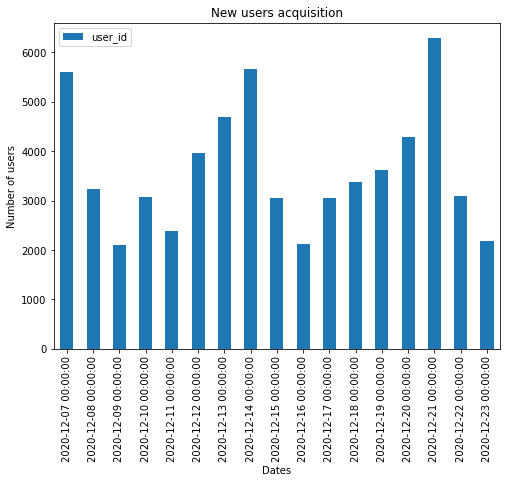

In [149]:
new_users.pivot_table(index='first_date', values='user_id', aggfunc='nunique')\
.plot(kind='bar', figsize=(8, 6))

plt.title('New users acquisition')
plt.xlabel('Dates')
plt.ylabel('Number of users')

### Conversion funnel

Let's go back to our funnel chart for a more detailed analysis.

In [150]:
#building a funnel chart
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = group_a['event_name'],
    x = group_a['user_id'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = group_b['event_name'],
    x = group_b['user_id'],
    textinfo = "value+percent initial")
             
             )

fig.update_layout(title="Conversion Funnel in Group A and B")

fig.show()

At the 1st stage of the transition from registration in the system to the product card, the conversion in group A is 65%, and in group B 56%, which is 9% lower. At the next stage (from the product card to the cart), the conversion in group B is 2% less than in the control group. At the stage of transition from the cart to the purchase in group B, there is a decrease of 4% compared to the control group A. It is also important to indicate that there are more users who have made a purchase than those who added items to their product carts. This may be due to the fact that the site has an option to purchase goods in one click, without going to the previous stages.

### Analyzing data features

Having cleaned out the data, we found that the input number of users of our test decreased significantly and the distribution of users in different groups turned out to be uneven. Before proceeding to the next stages of our analysis, it is necessary to calculate the minimum group size for AB testing. To do this, we'll use the following calculator:

https://www.evanmiller.org/ab-testing/sample-size.html

Baseline_conversion was set at 30%, which is the conversion in group A from login to purchase. The minimum effect we want to note is 10%. With a significance level of 5% and a test statistic of 80%, we need at least 337 users per group. We have enough users in Group A at every stage to evaluate the quality of AB testing. However, in group B, there is not enough data at the shopping cart and purchase step to assert the maximum reliability of our study.

## Evaluation of A/B testing results

The results of the AB testing showed that our expectations of improved conversions due to the new recommender system were not justified. We've seen a decrease in conversion at every stage of the funnel. To determine the statistical significance of this deterioration, I propose to test the shares according to the z criterion.

<b>H0</b>: Shares of converted users in groups A and B are equal. <b>Н1</b>: There are differences in the shares of converted users in groups A and B.

### Conducting z-test

In our case, we had to conduct multiple hypothesis tests on the same data. The more such tests we perform, the higher the probability of error. As we test the data only 3 times, we can choose the Bonferoni method to adjust the pvalue. To do this, in the formula, we divide the given level of significance by the number of tests, i.e. 0.5/3.

In [151]:
#function for ztest
def zetest(success_0, success_1, trial_0, trial_1):
    successes = np.array([success_0, success_1])
    trials = np.array([trial_0, trial_1])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    print(successes[0],successes[1] ,trials[0]  ,trials[1])
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    alpha = .05/3 #the Bonferoni method
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(p_value)
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no difference between the shares')

In [152]:
group_a

,event_name,user_id
0,login,2747
2,product_page,1780
1,product_cart,824
3,purchase,872


In [153]:
group_b

,event_name,user_id
0,login,927
2,product_page,523
1,product_cart,255
3,purchase,256


In [154]:
#product page stage
zetest(group_a.query('event_name == "product_page"')['user_id'], group_b.query('event_name == "product_page"')['user_id'],\
group_a.query('event_name == "login"')['user_id'], group_b.query('event_name == "login"')['user_id'])

[1780] [523] [2747] [927]
[5.08436808e-06]
We reject the null hypothesis: there is a significant difference between the shares


In [155]:
#product cart stage
zetest(group_a.query('event_name == "product_cart"')['user_id'], group_b.query('event_name == "product_cart"')['user_id'],\
       group_a.query('event_name == "login"')['user_id'], group_b.query('event_name == "login"')['user_id'])

[824] [255] [2747] [927]
[0.15034216]
It was not possible to reject the null hypothesis, there is no difference between the shares


In [156]:
#purchase stage
zetest(group_a.query('event_name == "purchase"')['user_id'], group_b.query('event_name == "purchase"')['user_id'],\
       group_a.query('event_name == "login"')['user_id'], group_b.query('event_name == "login"')['user_id'])

[872] [256] [2747] [927]
[0.01847463]
It was not possible to reject the null hypothesis, there is no difference between the shares


The decrease in conversion in group B at the product card stage was statistically significant.

# Conclusion

The purpose of our study is to evaluate the results of the AB testing. We needed to check the correctness of the test itself, identify possible problems with the data and analyze the results. During the research we:
- checked the data for its compliance with the technical task. When we found inconsistencies, we had to cut off inappropriate data. Unfortunately, as a result of data sorting and cleaning, we were left with fewer test participants than had expected. It was expected to get 6000 participants for the test, in fact we have only 3675 users left.
- our test overlapped in time with two pre-New Year marketing activities. Further analysis of the events showed no bursts of activity during the period of these campaigns, so it can be argued that these activities did not affect the behavior of test users.
- the distribution of events in the two groups showed a significant burst of activity in group A on December 14th, which could be a technical issue that needs more in depth investigation. 
- we have found an intersection of users in another AB test that was conducted at the same time, which of course can distort the results of the original test, since we cannot be sure which of the tests influenced the behavior of the users.
- the results of AB testing showed that our expectations of a 10% improvement in conversion compared to the control group did not justify itself. We saw a deterioration in conversions at all stages of the user funnel.
- this deterioration is statistically significant at the login-view product card stage. But as for other stages, there are doubts about the possibility of evaluating the test results, since according to the sample calculator, we did not get the required number of people in group B at the cart and purchase stages.

In general, we can conclude that there are concerns about the correctness of the test itself, and we did not see the expected improvement in user conversion results.

In my opinion the test has to be redone. There were several crucial errors in the test: simultaneous testing of several features (competitive test) and the intersection of users in these tests, premature termination of the test, lack of users in group B (checked using a sample calculator), unequal distribution of users in groups A and B (peak in group A on day 14).